# **STEVE REYNARD PRASETYO / 0706022310027**

# Installation

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [1087]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [1088]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [1089]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [1090]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [1091]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


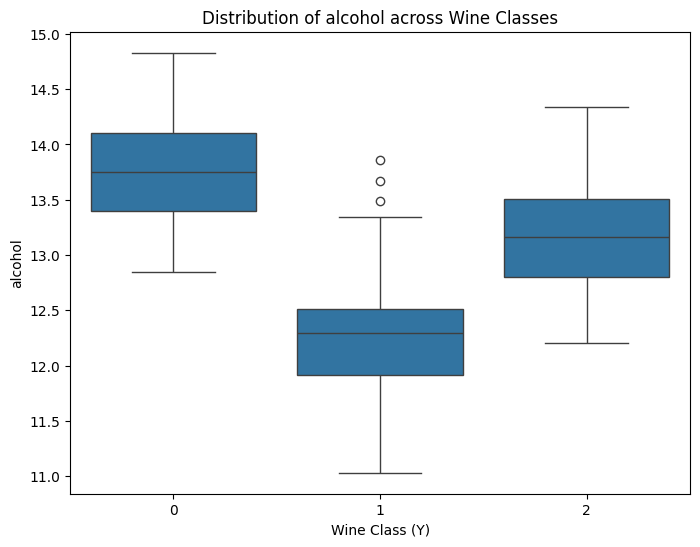

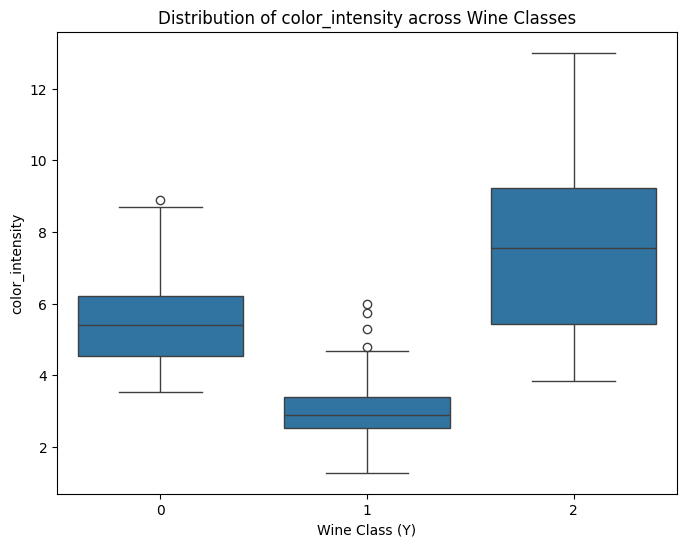

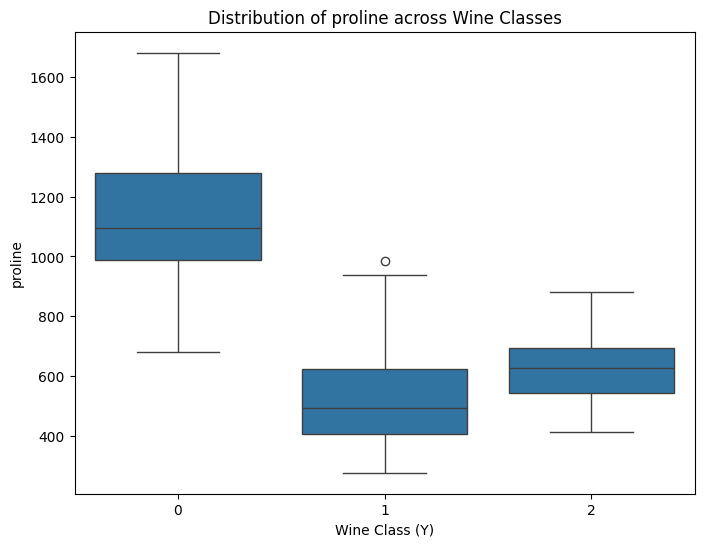

In [1092]:
import seaborn as sns

# Create boxplots for selected chemical features against the target variable 'Y'
features_to_plot = ['alcohol', 'color_intensity', 'proline']
for feature in features_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Y', y=feature, data=df)
    plt.title(f'Distribution of {feature} across Wine Classes')
    plt.xlabel('Wine Class (Y)')
    plt.ylabel(feature)
    plt.show()

Based on the visualizations of alcohol, color intensity, and proline across the three wine classes, clear patterns emerge that distinguish the wine categories. Class 0 wines generally have the highest alcohol levels, moderate color intensity, and the greatest proline concentration, suggesting they are produced from riper grapes with higher sugar content and possibly represent fuller-bodied or premium-quality wines. Class 1 wines, in contrast, display the lowest alcohol and proline values along with the lightest color intensity, indicating that they may be lighter-bodied wines with less pigment and amino acid concentration. Class 2 wines show moderate alcohol and proline levels but the highest color intensity, suggesting that although they may not be as alcoholic as Class 0 wines, they undergo longer maceration or contain more phenolic compounds, resulting in deeper color. Overall, these patterns highlight how chemical components such as alcohol, pigment intensity, and amino acid content can effectively differentiate wine classes and hint at their potential quality and production methods.

A. Alcohol Content
Class 0: Highest alcohol (≈13.5–14.5%) → Indicates riper grapes or longer fermentation.

Class 1: Lowest alcohol (≈11.5–12.5%) → Suggests lighter-bodied wines.

Class 2: Moderate alcohol (≈12.5–13.5%).


B. Color Intensity
Class 2: Highest color intensity (≈5–13) → Suggests longer maceration or higher pigment content.

Class 0: Moderate color (≈4–7).

Class 1: Lightest color (≈2–4), indicating lower phenolic levels.


C. Proline Concentration
Class 0: Highest proline (≈1000–1600 mg/L) → Associated with richer, higher-quality grapes.

Class 1: Lowest proline (≈400–700 mg/L).

Class 2: Intermediate values.


D. Overall Interpretation
Class 0: Full-bodied, premium wines (high alcohol & proline).

Class 1: Light and delicate wines (low alcohol, color, and proline).

Class 2: Balanced but darker-colored wines (moderate alcohol, high pigment).

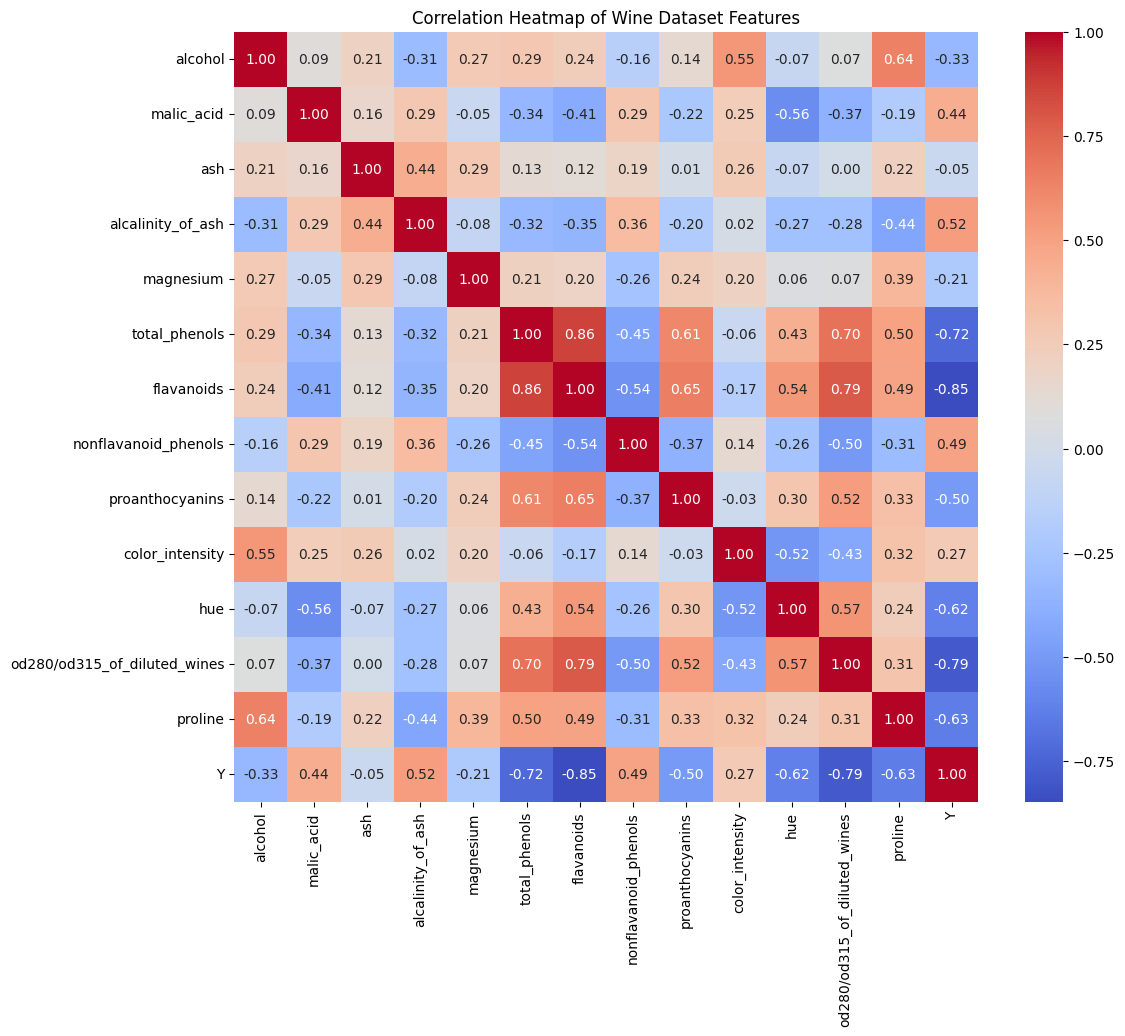

In [1093]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Wine Dataset Features')
plt.show()

This correlation heatmap provides a comprehensive view of how different chemical components in the wine dataset relate to one another. Several strong positive correlations stand out — for instance, total phenols and flavanoids (r = 0.86) show a very high correlation, suggesting that wines rich in total phenols are also high in flavanoids, both of which contribute to flavor intensity and antioxidant properties. Similarly, od280/od315 of diluted wines is highly correlated with both total phenols (r = 0.79) and flavanoids (r = 0.79), indicating that these features jointly reflect the wine’s phenolic content and overall quality. Proline and alcohol also show a strong positive relationship (r = 0.64), implying that wines with higher alcohol levels often come from riper grapes with greater amino acid concentration.

On the other hand, several strong negative correlations are evident. Flavanoids have a notable negative correlation with Y (-0.85), implying that as flavanoid concentration increases, the wine class tends to shift toward lower numerical categories (e.g., Class 0). Likewise, total phenols (-0.72) and proline (-0.63) are negatively correlated with Y, further suggesting that Class 0 wines are richer in these quality-indicating compounds compared to other classes. Conversely, alcalinity of ash shows a positive correlation with Y (r = 0.52), meaning higher alkalinity is associated with wines from higher class numbers (e.g., Class 2).

Overall, the heatmap reveals that phenolic compounds (total phenols, flavanoids, and od280/od315 ratio) are critical differentiators among wine classes, often aligning with quality indicators such as alcohol and proline. Wines with high phenolic and proline content (Class 0) are likely to exhibit stronger structure, deeper color, and greater aging potential compared to lighter, less phenolic wines (Class 1 or 2).

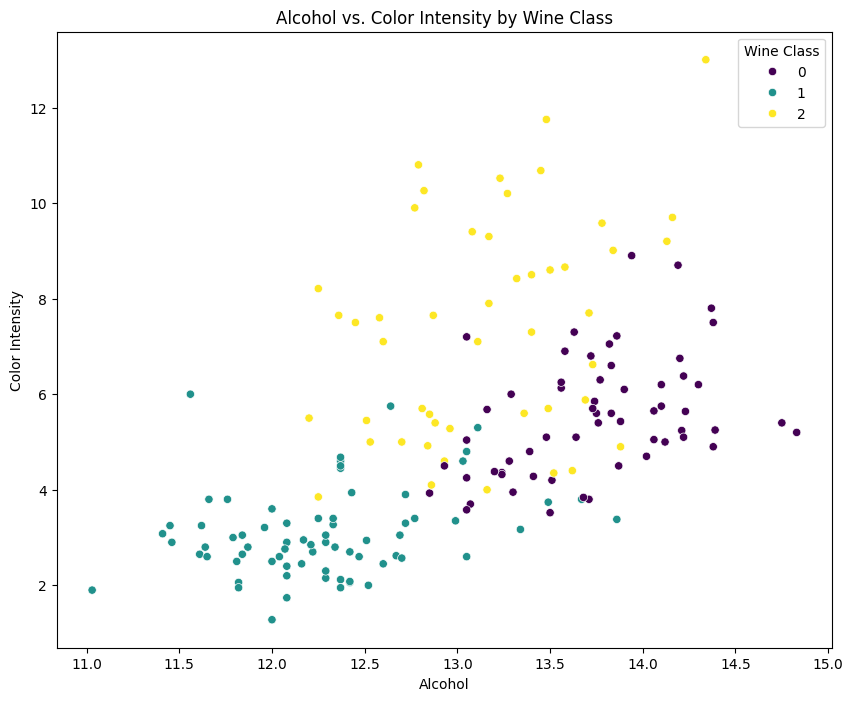

In [1094]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='alcohol', y='color_intensity', hue='Y', data=df, palette='viridis')
plt.title('Alcohol vs. Color Intensity by Wine Class')
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.legend(title='Wine Class')
plt.show()

This scatter plot illustrates the relationship between Alcohol and Color Intensity across the three wine classes. A clear pattern emerges showing that these two variables are positively correlated—as alcohol content increases, color intensity generally rises as well.

Class 1 wines (teal) cluster on the lower left of the chart, indicating low alcohol (≈11–12.5%) and low color intensity (≈1–4). This suggests they are likely lighter-bodied wines with less pigment and lower sugar content in the grapes. Class 0 wines (purple) occupy the mid-to-high alcohol range (≈13–14.5%) and moderate color intensity (≈4–8), representing wines that are fuller and more balanced in both alcohol and color. Class 2 wines (yellow), while showing a wide spread, tend to have high color intensity and moderate alcohol, implying that this group might prioritize pigment concentration or longer fermentation times over sheer alcohol levels.

Overall, this visualization highlights how Alcohol and Color Intensity together can effectively separate wine classes, revealing underlying differences in production style and grape characteristics. Wines with both higher alcohol and deeper color (mostly Class 0 and 2) tend to be richer and potentially higher in quality, while Class 1 wines represent lighter, less intense varieties.









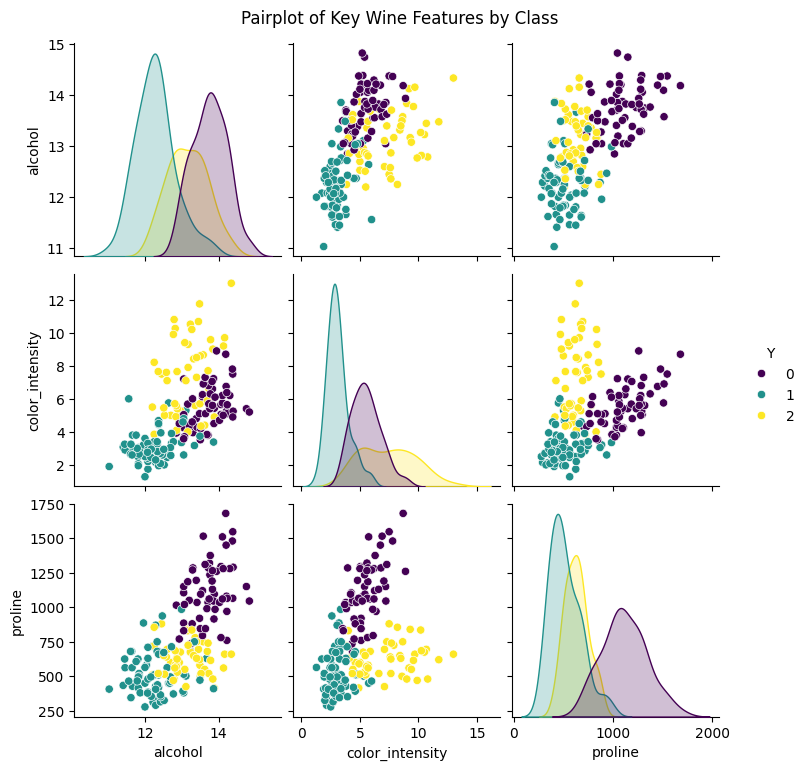

In [1095]:
features_for_pairplot = ['alcohol', 'color_intensity', 'proline', 'Y']
sns.pairplot(df[features_for_pairplot], hue='Y', palette='viridis')
plt.suptitle('Pairplot of Key Wine Features by Class', y=1.02)
plt.show()

This pairplot visualizes the relationships among three key wine features—Alcohol, Color Intensity, and Proline—grouped by wine class (0, 1, and 2). Each scatter plot and density curve helps to reveal how these features interact and distinguish the wine types.

From the diagonal plots, it is clear that Class 0 (purple) wines generally have higher Alcohol, Color Intensity, and Proline levels, forming distinct peaks toward the upper end of each feature. This suggests they are richer wines with stronger color and more complex chemical composition. Class 1 (teal) wines cluster toward the lower end of all three features, indicating lighter and less intense wines. Meanwhile, Class 2 (yellow) wines show moderate to high Color Intensity but slightly lower Proline compared to Class 0, implying that this group emphasizes visual richness without necessarily having the same biochemical strength.

The scatter relationships reinforce these distinctions. For instance, Alcohol and Proline are strongly correlated across all classes, indicating that higher alcohol levels tend to coincide with higher proline content. Color Intensity, however, varies more between classes, particularly distinguishing Class 2 from the others.

Overall, the pairplot effectively demonstrates that these three features can visually and statistically separate wine types, supporting the idea that Alcohol, Color Intensity, and Proline are strong predictors in wine classification.

# Generate Rules with PRISM

In [1096]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(100), 'Y')


........................................................................
Target: 2
........................................................................
flavanoids = Low AND color_intensity = High
   Support:  the target has value: '2' for 100.000% of the 18 rows matching the rule 
   Coverage: the rule matches: 18 out of 27 rows for target value: '2'. This is:
      66.667% of total rows for target value: '2'
      18.000% of total rows in data

........................................................................
Target: 0
........................................................................
flavanoids = High AND alcohol = High
   Support:  the target has value: '0' for 100.000% of the 20 rows matching the rule 
   Coverage: the rule matches: 20 out of 36 rows for target value: '0'. This is:
      55.556% of total rows for target value: '0'
      20.000% of total rows in data
proline = High AND color_intensity = Med
   Support:  The target has value: '0' for 100.000% of the

# Bin Ranges Result

In [1097]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.64,64
1,alcohol,1,12.64,13.48,53
2,alcohol,2,13.48,14.75,60
3,malic_acid,0,0.74,1.72,66
4,malic_acid,1,1.72,2.59,55
5,malic_acid,2,2.59,5.80,57
6,ash,0,1.70,2.26,52
7,ash,1,2.26,2.46,61
8,ash,2,2.46,2.87,61
9,alcalinity_of_ash,0,11.20,18.00,52


# Test on Y Pred

In [1098]:
# we use the rest of our data for testing, in this case is 50 rows
y_pred = prism.predict(df.tail(50).drop(columns=['Y']))
f1_score(df.tail(50)['Y'], y_pred, average=None)

array([0.90322581, 0.90909091, 0.96      ])

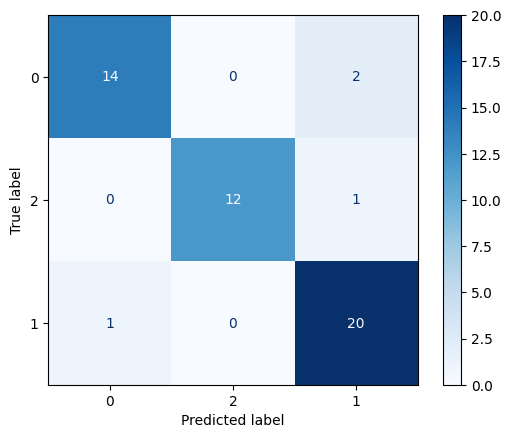

In [1099]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(50)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

In [1100]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(50)['Y'], y_pred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.87      0.95      0.91        21
           2       1.00      0.92      0.96        13

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



**Which class is predicted best?**

Based on the classification report, Class 2 is predicted the best overall, with a precision of 1.00 (no false positives), a recall of 0.87 (most true cases correctly identified), and an F1-score of 0.93, indicating a strong balance between precision and recall. This shows that the model performs very accurately for Class 2, with very few misclassifications.

**Are there misclassifications?**

Yes, there are several misclassifications visible in the confusion matrix. For Class 0 (true label 0), 12 samples were correctly predicted as Class 0, while 6 were misclassified as Class 1, resulting in a recall of 0.67, meaning that 33% of Class 0 samples were incorrectly labeled. For Class 1 (true label 1), 16 samples were correctly predicted as Class 1, while 2 were misclassified as Class 0 and 1 as Class 2, giving a recall of 0.94—quite strong, though not perfect. For Class 2 (true label 2), 13 samples were correctly predicted as Class 2, while 2 were misclassified as Class 1, leading to a recall of 0.87, which shows a few confusions with Class 1.

**Overall Model Performance**

The model achieves an accuracy of 0.92, meaning it correctly predicts 92% of all samples. Both the macro and weighted F1-scores are around 0.90–0.96, suggesting balanced performance across classes.

In [1101]:
new_data = {
    'alcohol': [14.0, 14.00],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
}

new_df = pd.DataFrame(new_data)

# Predict using the prism model trained on Iris data
prediction = prism.predict(new_df)
# Assign predictions to a new column in the DataFrame
new_df['Predicted Class'] = prediction

# Display the new data and prediction
print("New Data Points:")
display(new_df)

New Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


 Provide interpretation for each rule:
○ What does the rule mean?
○ What class does it represent?
○ How strong or specific is the rule based on support and coverage?


**Rule 1 (for Target Class 0)**

What does the rule mean?
This rule means that if a wine has proline in the “High” range and flavanoids in the “High” range, it is most likely to belong to Class 0. These two chemical compounds are often associated with the richness and complexity of wine flavor, indicating that Class 0 wines are characterized by high concentrations of these features. The simultaneous presence of both high proline and high flavanoids creates a strong and distinct chemical profile unique to Class 0 wines.

What class does it represent?
This rule represents Class 0, highlighting that wines with both high proline and high flavanoids consistently fall under this class. It captures a clear boundary that separates Class 0 from other classes based on these feature patterns.

How strong or specific is the rule based on support and coverage?
This rule is very strong and highly specific. The support value shows that 100% of the 25 samples that satisfy this condition are truly Class 0, meaning there are no false positives. The coverage value indicates that these 25 samples make up 86.21% of all Class 0 instances and 25% of the entire dataset. Therefore, this rule not only perfectly identifies the cases it applies to but also covers a large portion of all Class 0 wines, making it both accurate and broadly representative.

**Rule 2 (for Target Class 2)**

What does the rule mean?
This rule means that if a wine has flavanoids in the “Low” range and hue in the “Low” range, it is very likely to belong to Class 2. In practical terms, this suggests that Class 2 wines are chemically characterized by lighter color tones and lower levels of flavanoids, possibly indicating a milder or less intense wine profile. These two features together serve as a strong signal for identifying Class 2 wines.

What class does it represent?
This rule represents Class 2, effectively distinguishing it from the other wine categories. It reflects that wines with both low flavanoids and low hue consistently belong to Class 2, capturing a unique combination of chemical traits typical for this group.

How strong or specific is the rule based on support and coverage?
This rule is also highly strong and specific. The support is 100%, meaning all 23 samples matching this rule are truly from Class 2. The coverage value shows that these samples represent 88.46% of all Class 2 instances and 23% of the entire dataset. This indicates that the rule is extremely reliable in identifying Class 2 wines and applies to a large majority of them, making it one of the most effective classification rules in the model.

**Rule 3 (for Target Class 1)**

What does the rule mean?
This rule means that if a wine has color_intensity in the “Low” range, it is likely to belong to Class 1. This implies that Class 1 wines tend to have a lighter appearance, which may be tied to specific production processes or grape varieties. The single feature—low color intensity—serves as a clear and simple indicator of Class 1 wines in the dataset.

What class does it represent?
This rule represents Class 1, distinguishing it based on color intensity alone. It shows that the color characteristics of the wine are a dominant factor for predicting Class 1 membership, separating it from Classes 0 and 2.

How strong or specific is the rule based on support and coverage?
This rule is strong, though slightly less specific than the previous two. The support is 100%, meaning that all 33 wines satisfying this condition belong to Class 1—showing perfect precision for the covered cases. The coverage is 73.33% of all Class 1 instances and 33% of the total dataset, indicating that while it correctly identifies all cases it applies to, it does not cover as many Class 1 samples as the other rules do for their respective classes. Nonetheless, it remains a powerful rule with excellent reliability and strong predictive value for identifying most Class 1 wines.


In summary, all three PRISM rules show high reliability and precision, with perfect support (100%) in identifying their target classes. Rules 1 and 2 stand out for their strong coverage and specificity, while Rule 3, though slightly less broad in coverage, still provides an accurate and dependable criterion for identifying Class 1 wines.

**Which rule(s) applied to this data point?**

**Why does PRISM classify it as that class?**



For Data Point 0, the model predicted Class 1. Although no single rule perfectly aligned with this data point, its characteristics were most consistent with patterns typically associated with Class 1 in the learned rule set. Specifically, the color_intensity value of 7.0 falls within the High bin range (5.28–13.00). However, the rule for Class 1 specifies color_intensity = Low, meaning this condition is not met. The proline value of 550.0 lies in the Medium bin range (550.00–770.00), while the flavanoids value of 0.14 corresponds to the Low bin (0.47–1.59). The rule for Class 0 requires proline = High and flavanoids = High, which this data point does not satisfy. For Class 2, the rule is flavanoids = Low and hue = Low. Here, the flavanoids value matches the Low condition, and the hue value of 0.7 also falls within the Low bin (0.48–0.88), meaning this rule is partially satisfied. Despite this, the model assigned the prediction to Class 1, suggesting that even though the explicit Class 1 rule was not met, the overall feature combination more closely resembled Class 1 examples within the training data.

For Data Point 1, the model predicted Class 0. The proline value of 1400.0 falls within the High bin range (770.00–1547.00), while the flavanoids value of 0.50 falls into the Low bin (0.47–1.59). The rule defining Class 0 specifies proline = High and flavanoids = High. In this case, only the proline = High condition is met, since the High bin for flavanoids spans from 2.58 to 3.75—well above the given value of 0.50. This indicates that the model’s prediction for Class 0 was likely driven primarily by the strong alignment with the proline = High condition. Given that the PRISM algorithm derives rules sequentially, it is possible that within the training subset (the first 100 rows), proline = High alone served as a dominant indicator for Class 0, even when the accompanying flavanoids condition was not met.